# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import random
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

In [3]:
# First glance portfolio

print(portfolio.shape)
portfolio.head(10)

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# First glance at profile

print(profile.shape)
profile.head(10)

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [6]:
# First glance at transcript

print(transcript.shape)
transcript.head(20)

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


What looks odd is, that in profile there seem to be a lot of persons where no personal data is available. So I will have a closer look at those, to figure out, wether there is always all data missing, or sometimes just some.

In [7]:
pers_no_data_age = profile[profile['age']==118]
print('age == 118: %s' %len(pers_no_data_age))
print('Values for gender: %s' %pers_no_data_age['gender'].unique())
print('Values for income: %s' %pers_no_data_age['income'].unique())

pers_no_data_gender = profile[profile['gender'].isnull()]
print('gender == None: %s' %len(pers_no_data_gender))
print('Values for age: %s' %pers_no_data_gender['age'].unique())
print('Values for income: %s' %pers_no_data_gender['income'].unique())

pers_no_data_income = profile[profile['income'].isnull()]
print('income == NaN: %s' %len(pers_no_data_income))
print('Values for age: %s' %pers_no_data_income['age'].unique())
print('Values for gender: %s' %pers_no_data_income['gender'].unique())

age == 118: 2175
Values for gender: [None]
Values for income: [ nan]
gender == None: 2175
Values for age: [118]
Values for income: [ nan]
income == NaN: 2175
Values for age: [118]
Values for gender: [None]


Out of the 17000 people for 2175 of them no personal data is available. But it is "all or nothing". So either all personal data is available or none.


Next I will do some basic cross checks, to check wether all transactions are related to people from the profile file and all values with an offer id to an offer from the protfolio file.

In [8]:
trans_no_person_from_dataset = transcript[~transcript['person'].isin(profile['id'])]
print('%s transactions by persons not in profile.'%trans_no_person_from_dataset.shape[0])

values = transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x.keys() else portfolio['id'][0])
ids_not_in_dataset = set(values) - set(portfolio['id'])
print('%s transaction ids not in dataset'%len(list(ids_not_in_dataset)))

0 transactions by persons not in profile.
0 transaction ids not in dataset


So far the dataset seems consistent. There are no transactions with a person or offer reference that is not in the dataset.


Next I will have a look, how many transactions can be related to those people without any personal data available:

In [9]:
transcripts_no_personal_data = transcript[transcript['person'].isin(pers_no_data_age['id'])]
print(transcripts_no_personal_data.shape)
events_no_personal_data = transcripts_no_personal_data['event'].value_counts()
print(events_no_personal_data)

(33772, 4)
transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: event, dtype: int64


And next how many can be related to all others

In [10]:
transcripts_w_personal_data = transcript[~transcript['person'].isin(pers_no_data_age['id'])]
print(transcripts_w_personal_data.shape)
events_w_personal_data = transcripts_w_personal_data['event'].value_counts()
print(events_w_personal_data)

(272762, 4)
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64


The persons who do not give any personal data seem to differ from those who do give their personal data. the biggest difference is, that for persons who do not give any personal data, the offer completion rate is between 10% and 15%, whereas the rate for those who do is close to 50%.

Next I will do some categorizations for income and age, to group people better:

In [4]:
def add_bins(df, column, num_bins, intervals=[]):
    """
    adds a column with bins to the dataframe in order to cluster certain aspects.
    
    Arguments:
    -------------------
    df:         Dataframe to add bins to
    column:     Name of column to transfer to bins
    num_bins:   Number of bins
    
    
    Returns:
    -------------------
    df:         New Dataframe with column of bins added. Name of that columns is <column>_bins
    borders:    The borders of the bins
    
    """
    
    new_col_name = column + '_bins'
    
    # if column with name <column>_bins already exists, drop it
    
    if new_col_name in df.keys():
        df.drop(new_col_name, axis=1)
    
    
    new_col = []
    borders = []
    
    # if intervals is given use them, else make it equidistant
    
    if num_bins == len(intervals):    
        new_col, borders = pd.cut(df[column], intervals, retbins=True, labels=False)
        
    else:
        new_col, borders = pd.cut(df[column], num_bins, retbins=True, labels=False)
        
    df[new_col_name] = new_col
    
    return df, borders
        

In [5]:
# Replace age 118 with Nan, so it is not taken into account for the bins

profile = profile.replace(118, np.nan)

# get groups for age and income
profile_w_bins, age_borders = add_bins(profile, 'age', 7)
profile_w_bins, income_borders = add_bins(profile_w_bins, 'income', 7)
profile_w_bins.head(20)

,age,became_member_on,gender,id,income,age_bins,income_bins
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0,6.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0,5.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4.0,3.0
6,NaN,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN
7,NaN,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,3.0,1.0
9,NaN,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,NaN,NaN


In [59]:
print(age_borders)
print(income_borders)

[  17.917        29.85714286   41.71428571   53.57142857   65.42857143
   77.28571429   89.14285714  101.        ]
[  29910.           42857.14285714   55714.28571429   68571.42857143
   81428.57142857   94285.71428571  107142.85714286  120000.        ]


Next I will have a look at some persons individually categorized by the four different types in transcript.

In [13]:
# split persons 5be88f96bada400cbc6216018b249a01, 38fe809add3b4fcf9315a9694bb96ff5, dc1caa5f072c4f8690b900279e01692d
person_id = 'dc1caa5f072c4f8690b900279e01692d'
offers_received_by_person = transcript[transcript.person.isin([person_id]) & transcript.event.isin(['offer received'])]
offers_viewed_by_person = transcript[transcript.person.isin([person_id]) & transcript.event.isin(['offer viewed'])]
offers_completed_by_person = transcript[transcript.person.isin([person_id]) & transcript.event.isin(['offer completed'])]
transactions_by_person = transcript[transcript.person.isin([person_id]) & transcript.event.isin(['transaction'])]
print(len(offers_received_by_person))
print(len(offers_viewed_by_person))
print(len(offers_completed_by_person))
print(len(transactions_by_person))

5
4
1
3


In [14]:
offers_received_by_person

,event,person,time,value
1617,offer received,dc1caa5f072c4f8690b900279e01692d,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
112443,offer received,dc1caa5f072c4f8690b900279e01692d,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
160383,offer received,dc1caa5f072c4f8690b900279e01692d,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
211281,offer received,dc1caa5f072c4f8690b900279e01692d,504,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
246716,offer received,dc1caa5f072c4f8690b900279e01692d,576,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [15]:
offers_viewed_by_person

,event,person,time,value
99119,offer viewed,dc1caa5f072c4f8690b900279e01692d,270,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
185194,offer viewed,dc1caa5f072c4f8690b900279e01692d,450,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
214796,offer viewed,dc1caa5f072c4f8690b900279e01692d,504,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
262534,offer viewed,dc1caa5f072c4f8690b900279e01692d,582,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [16]:
offers_completed_by_person

,event,person,time,value
214798,offer completed,dc1caa5f072c4f8690b900279e01692d,504,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...


In [17]:
transactions_by_person

,event,person,time,value
137707,transaction,dc1caa5f072c4f8690b900279e01692d,366,{'amount': 18.01}
214797,transaction,dc1caa5f072c4f8690b900279e01692d,504,{'amount': 19.58}
218858,transaction,dc1caa5f072c4f8690b900279e01692d,510,{'amount': 18.7}


Considering the first offer that was received and viewed it is clear, that the duration in portfolio has to start at the time the user views the offer, not the time the user receives the offer, as stated in the introduction.


# Data Visualization

This shows the number and distributions of income and age depending on gender

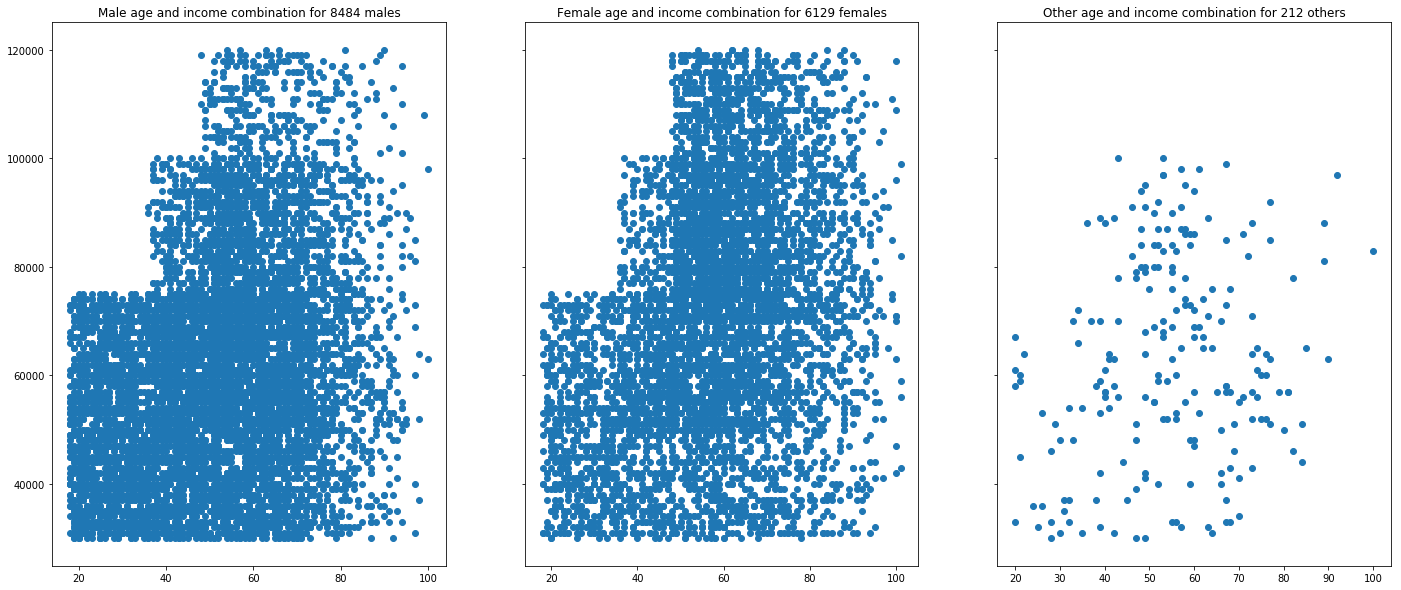

In [18]:
males = profile[profile.gender == 'M']
females = profile[profile.gender == 'F']
other = profile[profile.gender == 'O']

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize= [24,10])
ax1.scatter(males['age'], males['income'])
ax1.title.set_text('Male age and income combination for %s males'%(len(males)))
ax2.scatter(females['age'], females['income'])
ax2.title.set_text('Female age and income combination for %s females'%(len(females)))
ax3.scatter(other['age'], other['income'])
ax3.title.set_text('Other age and income combination for %s others'%(len(other)))

In [19]:
print('Avergage female age: %s'%(females['age'].mean()))
print('Avergage female income: %s'%(females['income'].mean()))
print('Avergage male age: %s'%(males['age'].mean()))
print('Avergage male income: %s'%(males['income'].mean()))
print('Avergage other age: %s'%(other['age'].mean()))
print('Avergage other income: %s'%(other['income'].mean()))

Avergage female age: 57.5449502366
Avergage female income: 71306.412139
Avergage male age: 52.1166902405
Avergage male income: 61194.601603
Avergage other age: 54.4009433962
Avergage other income: 63287.7358491


There are more males than females and only a very few others.
In average te male participants are the youngest and once with lowest income, whereas the females are the oldest and have the highest income.
This seems consistent with the fact that there seems to be at least some correlation between age and income.

Looking at the portfolio, there are three different kinds of offers. Two just informational once, four Bogos (buy one get one free) and four with a discount. They each have different duration, difficulty and reward.

So next I will have a look at how often each offer type was received, viewed and completed.

In [20]:
# get transcript by different offer actions
offers_received = transcript[transcript.event.isin(['offer received'])]
offers_viewed = transcript[transcript.event.isin(['offer viewed'])]
offers_completed = transcript[transcript.event.isin(['offer completed'])]

# sort portfolio by offer type
pf_sorted = portfolio.sort_values('offer_type')

# init data
num_received = []
num_viewed = []
num_completed = []
description = []

categories = []
nums_per_cat = []
num_cat = 0

# get numbers received for each offer type and some meta data like description and categories
for index, offer in pf_sorted.iterrows():
    
    description.append('Index: %s, Diff: %s, Dur: %s, Rew: %s'%(index, offer.difficulty, offer.duration, offer.reward))
    if offer['offer_type'] not in categories:
        if num_cat > 0:
            nums_per_cat.append(num_cat) 
        categories.append(offer['offer_type'])    
    num_cat += 1
    Sum = 0
    for offerid in offers_received['value']:
        if offerid['offer id'] == offer.id:
            Sum += 1
    num_received.append(Sum)

# get numbers viewed for each offer type
for _, offer in pf_sorted.iterrows():
    Sum = 0
    for offerid in offers_viewed['value']:
        if offerid['offer id'] == offer.id:
            Sum += 1
    num_viewed.append(Sum)

# get numbers completed for each offer type    
for _, offer in pf_sorted.iterrows():
    Sum = 0
    for offerid in offers_completed['value']:
        if offerid['offer_id'] == offer.id:
            Sum += 1
    num_completed.append(Sum)


num_cats_rec = [sum(num_received[:nums_per_cat[0]]), sum(num_received[nums_per_cat[0]:nums_per_cat[1]]), sum(num_received[nums_per_cat[1]:])]
num_cats_view = [sum(num_viewed[:nums_per_cat[0]]), sum(num_viewed[nums_per_cat[0]:nums_per_cat[1]]), sum(num_viewed[nums_per_cat[1]:])]
num_cats_comp = [sum(num_completed[:nums_per_cat[0]]), sum(num_completed[nums_per_cat[0]:nums_per_cat[1]]), sum(num_completed[nums_per_cat[1]:])]

print(num_cats_rec)
pf_sorted.head(10)

[30499, 30543, 15235]


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


The graphs below show the distribution of each offer for receiving, viewing and completion.
The last two also show the rate compared to the former.

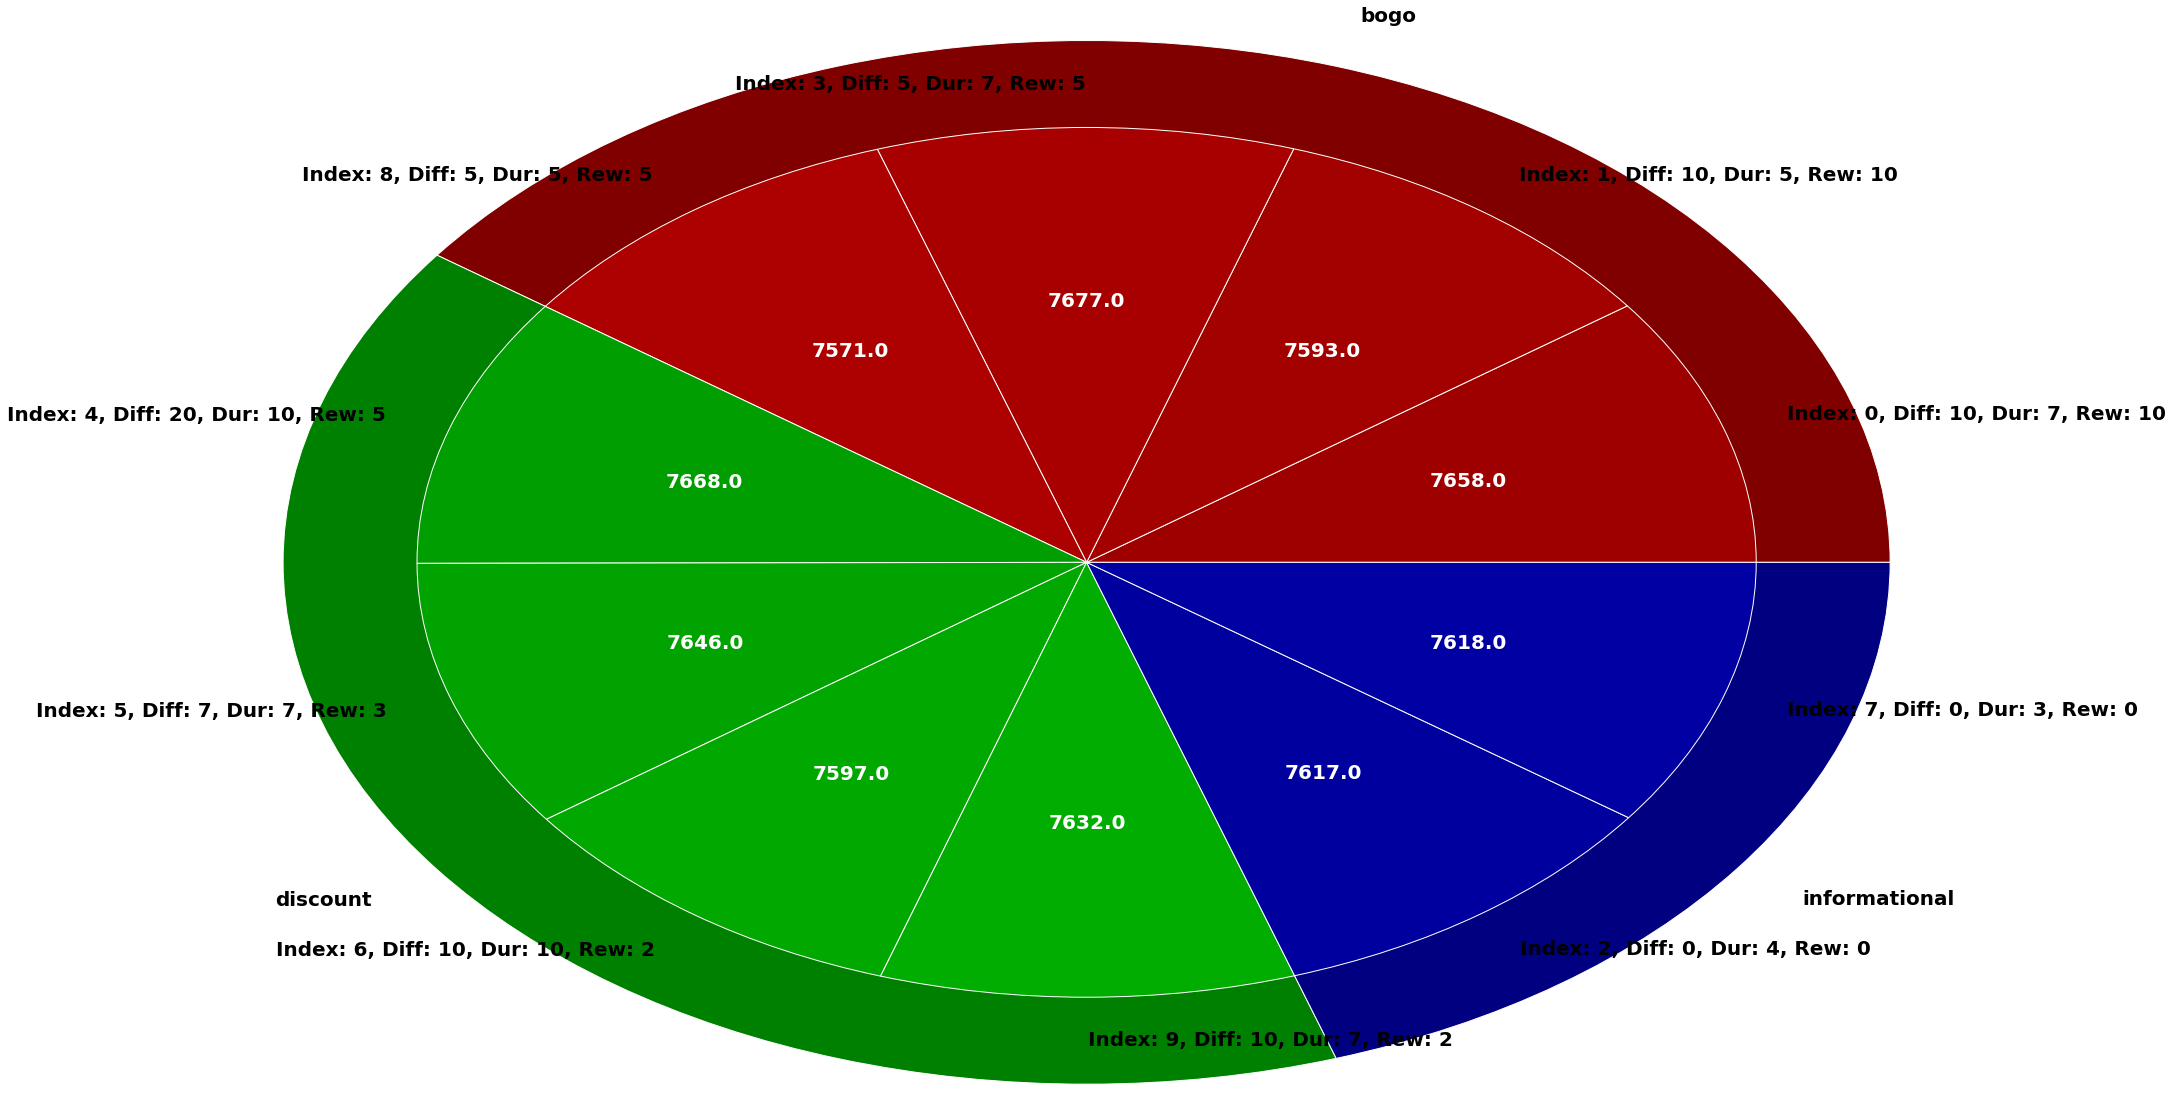

In [21]:
# plot offers received

fig, ax = plt.subplots()

size = 5

outer_colors = [[0.5, 0., 0.], [0., 0.5, 0.], [0., 0., 0.5]]
inner_colors = [[0.62, 0., 0.], [0.64, 0., 0.], [0.66, 0., 0.], [0.68, 0., 0.],
               [0., 0.62, 0.], [0., 0.64, 0.], [0., 0.66, 0.], [0., 0.68, 0.],
               [0., 0., 0.62], [0., 0., 0.64]]

wedges1, texts1 = ax.pie(num_cats_rec, radius=6, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=categories)
wedges2, texts2, autotexts2 = ax.pie(num_received, radius=5, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=description, autopct=lambda x:np.round(x/100 * sum(num_cats_rec)))


plt.setp(autotexts2, size=20, weight="bold", color='white')
plt.setp(texts1, size=20, weight="bold", color='black')
plt.setp(texts2, size=20, weight="bold", color='black')
plt.show()

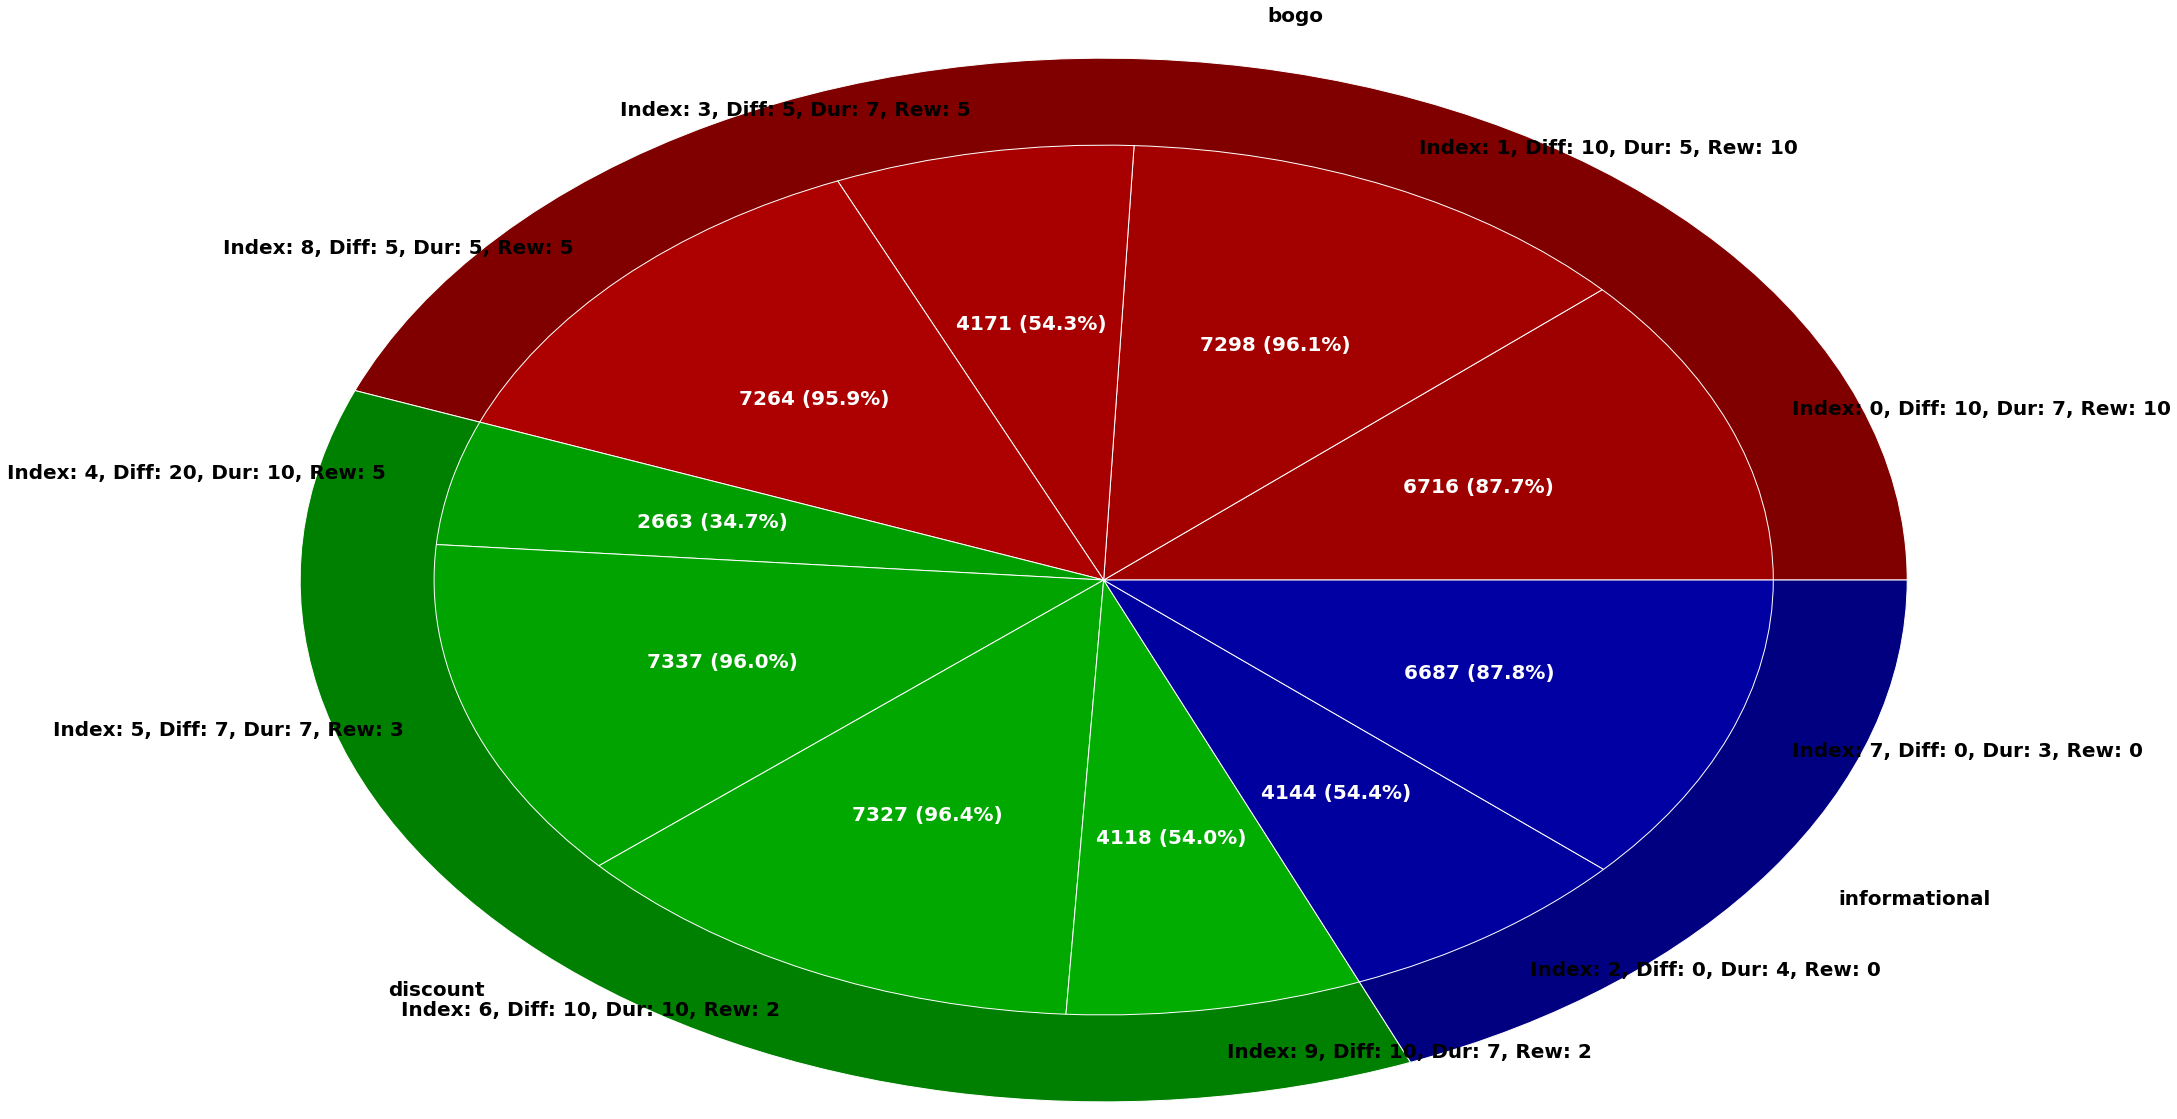

In [22]:
# plot offers viewed

fig, ax = plt.subplots()

size = 5

outer_colors = [[0.5, 0., 0.], [0., 0.5, 0.], [0., 0., 0.5]]
inner_colors = [[0.62, 0., 0.], [0.64, 0., 0.], [0.66, 0., 0.], [0.68, 0., 0.],
               [0., 0.62, 0.], [0., 0.64, 0.], [0., 0.66, 0.], [0., 0.68, 0.],
               [0., 0., 0.62], [0., 0., 0.64]]

def get_labels_v(x, num_viewed, num_received):
    val = np.round(x/100 * sum(num_viewed))
    idx = num_viewed.index(val)
    rate = val /num_received[idx] *100
    
    return "%i (%.1f%%)"%(val, rate)
    

wedges1, texts1 = ax.pie(num_cats_view, radius=6, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=categories)
wedges2, texts2, autotexts2 = ax.pie(num_viewed, radius=5, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=description, autopct=lambda x: get_labels_v(x, num_viewed, num_received))

plt.setp(autotexts2, size=20, weight="bold", color='white')
plt.setp(texts1, size=20, weight="bold", color='black')
plt.setp(texts2, size=20, weight="bold", color='black')
plt.show()

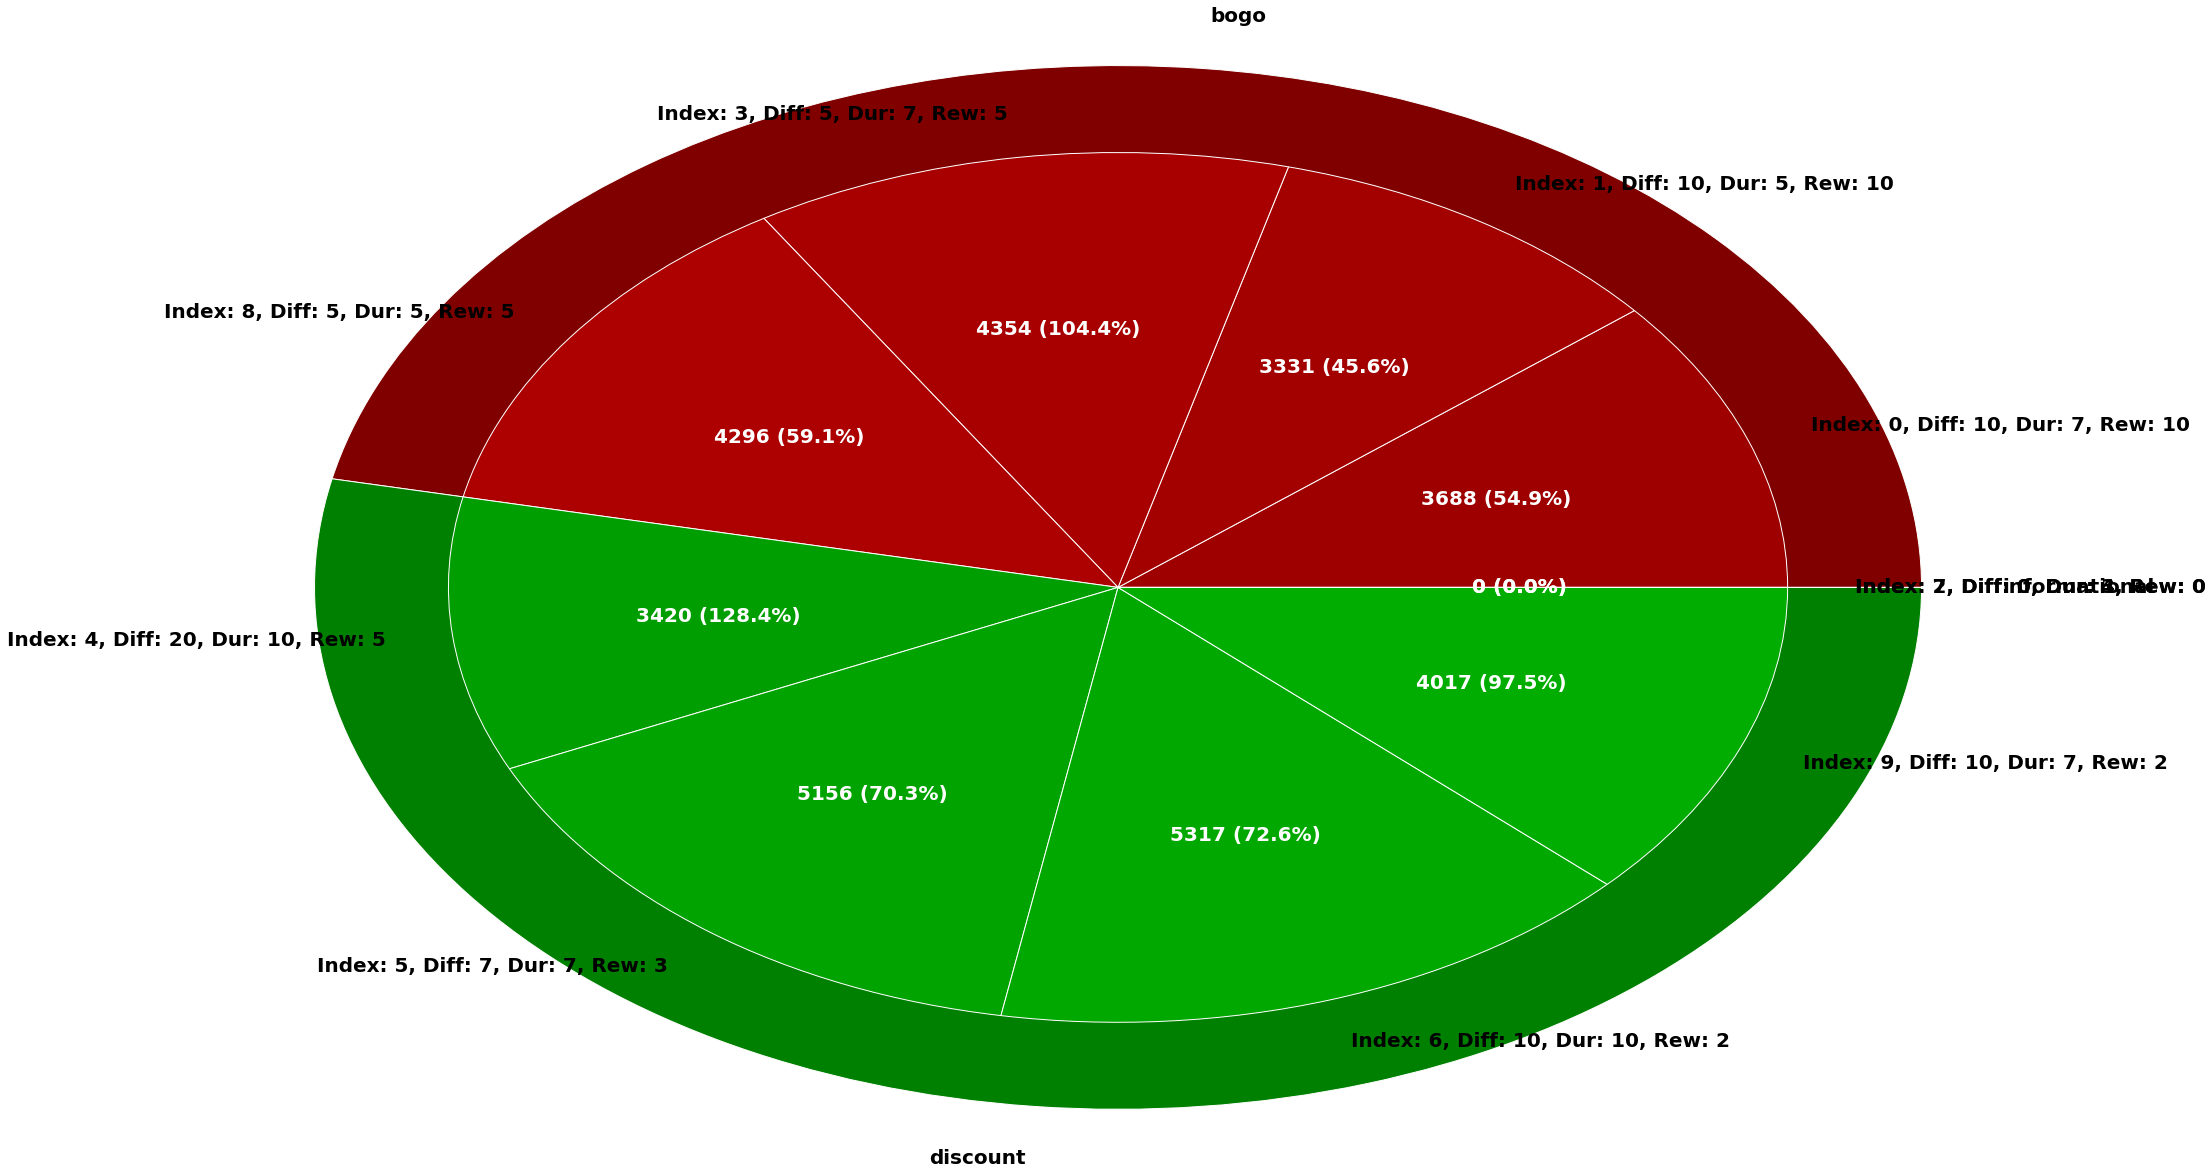

In [23]:
# plot offers completed

fig, ax = plt.subplots()

size = 5

outer_colors = [[0.5, 0., 0.], [0., 0.5, 0.], [0., 0., 0.5]]
inner_colors = [[0.62, 0., 0.], [0.64, 0., 0.], [0.66, 0., 0.], [0.68, 0., 0.],
               [0., 0.62, 0.], [0., 0.64, 0.], [0., 0.66, 0.], [0., 0.68, 0.],
               [0., 0., 0.62], [0., 0., 0.64]]

def get_labels_c(x, num_completed, num_viewed):
    val = np.round(x/100 * sum(num_completed))
    idx = num_completed.index(val)
    rate = val /num_viewed[idx] *100
    
    return "%i (%.1f%%)"%(val, rate)

wedges1, texts1 = ax.pie(num_cats_comp, radius=6, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=categories)
wedges2, texts2, autotexts2 = ax.pie(num_completed, radius=5, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=description, autopct=lambda x: get_labels_c(x, num_completed, num_viewed))

plt.setp(autotexts2, size=20, weight="bold", color='white')
plt.setp(texts1, size=20, weight="bold", color='black')
plt.setp(texts2, size=20, weight="bold", color='black')
plt.show()

It can be seen, that the different kind of offers have a very different view and completion rate. This raises the question, whether there is some sort of preview for the user, that canno be seen in the data. For example offer 4 has a view rate of only ~35%, whereas offers 1, 5, 6 and 8 have a rate of at ~96%.


With the exception of offer 6 it can be see, that higher difficulty leads to less completions. (Informational offers cannot be completed).
IT also looks like, that the amount of the reward does not seem to play a big role in the completion rate, so offers with a little discount seem to have an equal (or sometimes even higher) effect as those with a high reward. So from a business perspective it does not seems to be necessary to issue high rewards.

# Data Preparation

The model I want to train will make predictions on how much a user will spend, given the personal data and history.
I think not only the personal data like age, income and gender plays a role, but also the personal history. There might be middle aged females with an average income who buy stuff regularaly and others who are very much driven by offers. So why not take the personal history into consideration?

In order to do that, I will first split the dataset into training and testing persons.

### Goal to reach

After that I will set up a Dataframe that gets a new Datapoint, each time the status of a user changes. So if a user views and offer, completes and offer (that was viewed earlier), or if an offer expires, the status changes.

So besides the personal data I will extend my input by the following columns:

    has_offer_x:                          This is the number of offers of that type that are currently open
    has_viewed_offer_x:                   This is the number times the user has viewed that offer in the past
    has_viewed_and_completed_offer_x:     This is the number times the user has viewed and completed that offer in the past
    money_spent_after_viewed_offer_x:     This is the summed up amount of money the user has spend after seing that offer, while it was still active, up to now
    total_time_offer_viewed_active_x:     This is the summed up amount of time that offer was active for that user up to now
    
If no offer is active, the time and money spent will be added to time_no_active_offer and money_spend_no_offer. 

The avg_spend_per_hour is the label. It is the average money spent per hour by a user, that has a certain status. So the compnies intereset would be, to have a very high value here.


### Difficulties:

One difficulty is, how to handle multiple open offers at the same time. I decided to add the money and time to all active offers. If an offer of the same time is active more than once, the amount and time will be added more than once as well.

Since I am also taking the personal history into account, I do not see the need to delete those persons, who did not give any personal background.


In [6]:
def create_data_point(user, portfolio, active_offers, amounts, times, time_no_active, amount_no_offer,
                      time_period, money_spent, num_viewed, num_viewed_completed, timestamp):
    """
    create a datapoint for the current situation of that user.
    
    
    Arguments:
    -------------------
    user:                 the relevant user
    portfolio:            as defined at the beginnig
    active_offers:        list of currently open offers
    amounts:              Summed up amounts spend on each offer type
    times:                Summed up times each offer type was active
    time_no_active:       Summed up time no offer was active
    amount_no_offer:      Summed up amount, while no offer was active
    time_period:          Duration of that status
    money_spent:          Money spent since the last datapoint
    num_viewed:           Number of times each offered was viewed
    num_viewed_completed: Number of times each offer was viewed and completed
    timestamp:            Current timestamp
    
    Returns:
    -------------------
    data_point :           a new data point containing the input and label columns.
                           inputs:
                           age, income gender: personal data
                           has_offer_: how often this offer is active at the time
                           has_viewed_offer_: how many times user has viewed an offer of that type upt to this point
                           has_viewed_and_completed_offer_: how many times user has viewedand completed an offer of that type upt to this point
                           money_spent_after_viewed_offer_: how much money was spent after vieweing an offer of that type
                           total_time_offer_viewed_active_: how long offers of that type were open
                           money_spend_no_offer: money spent while no offer was active
                           time_no_active_offer: time period no offer was active
                           avg_spend_per_hour: lable, how much is in average spend per hour with current status, until status changes
    """
    
    # personal data
    data_point = [user.age_bins, user.income_bins, user.gender]
    
    # offer specific data
    for offer_id in portfolio['id'].values:
        num = active_offers.count(offer_id)
        data_point.append(num)            
        data_point.append(num_viewed[offer_id])
        data_point.append(num_viewed_completed[offer_id])
        data_point.append(amounts[offer_id])
        data_point.append(times[offer_id])
    
    # no offer
    data_point.append(amount_no_offer)
    data_point.append(time_no_active)

    # label    
    if time_period > 0:
        data_point.append(money_spent / time_period)
    else:
        data_point.append(money_spent)
    
    # general information, debug (not used in ml model)
    data_point.append(user.id)
    data_point.append(timestamp)
    data_point.append(time_period)
    data_point.append(money_spent)
        
    return data_point


In [7]:
def check_expired(data_points, timestamp, user, portfolio, active_offers, amounts, times, time_no_active, amount_no_offer,
                    money_spent, num_viewed, num_viewed_completed, expiration_time, view_time, last_data_point):
    """
    check wether one or more offered is expired at a certain timestamp.
    If an offered has expired, a new datapoint is created, due to the new situation.
    
    
    Arguments:
    -------------------
    data_points:          Already created datapoints
    timestamp:            Relevant timestamp to check for expiration
    user:                 the relevant user
    portfolio:            as defined at the beginnig
    active_offers:        list of currently open offers
    amounts:              Summed up amounts spend on each offer type
    times:                Summed up times each offer type was active
    time_no_active:       Summed up time no offer was active
    amount_no_offer:      Summed up amount, while no offer was active
    money_spent:          Money spent since the last datapoint
    num_viewed:           Number of times each offered was viewed
    num_viewed_completed: Number of times each offer was viewed and completed
    expiration_time:      List of expiration times for active offers
    view_time:            List of view times for all active offers
    last_data_point:      Timestamp of last datapoint
    
    Returns:
    -------------------
    data_points:          Already created datapoints
    last_expiration:      Timestamp of latest expiration
    amounts:              Summed up amounts spend on each offer type
    times:                Summed up times each offer type was active
    expiration_time:      List of expiration times for active offers
    view_time:            List of view times for all active offers
    active_offers:        list of currently open offers
    money_spent:          Money spent since the last datapoint
    time_no_active:       Summed up time no offer was active
    amount_no_offer:      Summed up amount, while no offer was active
    last_data_point:      Timestamp of last datapoint
    """
      
    expired = []
    last_expiration= 0
    ctr_removed = 0
    
    # transform list of expiration times and sort it chronologically
    exp_times = enumerate(deepcopy(expiration_time))
    sorted_exp_times = sorted(exp_times, key=lambda x:x[1])
    
    # check wether each offer expired
    for _, offer_exp_time in sorted_exp_times:
        if offer_exp_time < timestamp:
            index = expiration_time.index(offer_exp_time)
            offer_id = active_offers[index]
            time_period = offer_exp_time - last_data_point
            
            # if offer expired, create datapoint accordingly, add times and amounts and clear data
            if time_period > 0:
                data_points.append(create_data_point(user, portfolio, active_offers, amounts, times, time_no_active,
                    amount_no_offer, time_period, money_spent, num_viewed, num_viewed_completed, offer_exp_time))
                
            if len(active_offers) > 0:
                for offer in active_offers:
                    times[offer] += time_period
                    amounts[offer] += money_spent
            else:
                time_no_active += time_period
                amount_no_offer += money_spent
                
            money_spent = 0
            last_data_point = offer_exp_time

            del expiration_time[index]
            del view_time[index]
            del active_offers[index]
            

    return data_points, last_expiration, amounts, times, expiration_time, view_time, active_offers, money_spent, time_no_active, amount_no_offer, last_data_point

In [8]:
def create_ml_data(user, transcript, portfolio, init_dict, category_dict, max_offer_duration, max_timestamp):
    """
    creates the data table for the machine learning model. Each row is one datapoint.
    A new datapoint is created, every time the situation of a user changes, which happens, when an offer is viewed
    for the first time, an offer is completed, or an offer has expired.
    For all transactions the money is summed up until the next datapoint is created. Then the money is devided by the timespan
    between those two events, to get the money spent per time, which will serve as the label.
    
    Arguments:
    -------------------
    user:                 The user it runs for (pandas series)
    transcript:           Dataframe with all transcriptions as defined at the top of this program
    init_dict:            dictionary with all offer ids as keys
    category_dict:        dict with all categories
    max_offer_duration:   dict with all offer durations
    max_timestamp:        max timestamp in transcript
    
    
    Returns:
    -------------------
    data_points:           a list of all data points containing the input and label columns.
                           inputs:
                           age, income gender: personal data
                           has_offer_n: how often this offer is active at the time
                           has_viewed_offer_: how many times user has viewed an offer of that type upt to this point
                           has_viewed_and_completed_offer_: how many times user has viewedand completed an offer of that type upt to this point
                           money_spent_after_viewed_offer_: how much money was spent after vieweing an offer of that type
                           total_time_offer_viewed_active_: how long offers of that type were open
                           money_spend_no_offer: money spent while no offer was active
                           time_no_active_offer: time period no offer was active
                           avg_spend_per_hour: lable, how much is in average spend per hour with current status, until status changes
    """
    
    personal_transcripts = transcript[transcript.person.isin([user['id']])]
    offers_received = personal_transcripts[personal_transcripts.event.isin(['offer received'])]
    offers_completed = personal_transcripts[personal_transcripts.event.isin(['offer completed'])]
    
    data_points = []                              # data points created
    active_offers = []                            # list of currently active offers
    view_time = []                                # view time of that offer (timestamp whe it was viewed)
    expiration_time = []                          # expiration time of that offer (timestamp whe it will expire)
    amounts = deepcopy(init_dict)                 # amounts spend djuring each offer
    times = deepcopy(init_dict)                   # time period while this offer was available
    num_viewed = deepcopy(init_dict)              # number of times this offer was viewed
    num_viewed_completed = deepcopy(init_dict)    # number of times this offer was viewed and completed
    time_no_active = 0                            # time period no offer was active
    last_data_point = 0                           # timestamp of last data point
    amount_no_offer = 0                           # amount spend with no active offer
    money_spent = 0                               # money spent since last datapoint
    
    # iterate over offers viewed
    if len(personal_transcripts) > 0:
        for index, action in personal_transcripts.iterrows():
            
            # check wether one or more offers expired and get datapoints accordingly and reset necessary data
            
            if len(expiration_time) != len(view_time) or len(expiration_time) != len(active_offers):
                print('Warning unequal length of arrays, user: %s, timestamp: %s'%(user.id, action.time))
            
            data_points, last_expiration, amounts, times, expiration_time, view_time, active_offers, money_spent, time_no_active, amount_no_offer, last_data_point = check_expired(data_points,
            action.time, user, portfolio, active_offers, amounts, times, time_no_active, amount_no_offer,
                    money_spent, num_viewed, num_viewed_completed, expiration_time, view_time, last_data_point)
            

            # add money to current stack
            if action.event == 'transaction':
                    
                money_spent += float(action.value['amount'])
                    
                    
            # clear offer and set time this offer was active.
            elif action.event == 'offer completed':
                
                offer_id = action.value['offer_id']
                
                if offer_id in active_offers:
                    index = active_offers.index(offer_id)
                    # create new data point
                    time_period = action.time - last_data_point
                    if time_period > 0:
                        data_points.append(create_data_point(user, portfolio, active_offers, amounts, times, time_no_active,
                            amount_no_offer, time_period, money_spent, num_viewed, num_viewed_completed, action.time))
                        
                        if len(active_offers) > 0:
                            for offer in active_offers:
                                times[offer] += time_period
                                amounts[offer] += money_spent
                        else:
                            time_no_active += time_period
                            amount_no_offer += money_spent
                            
                        money_spent = 0
                        last_data_point = action.time

                    # clear offer and reset expiration date
                    active_offers.remove(offer_id)
                    del expiration_time[index]

                    # add time this offer was active
                    time_passed = action.time - view_time[index]
                    if max_offer_duration[offer_id] > time_passed:
                        num_viewed_completed[offer_id] += 1

                    del view_time[index]
              
                
            # add offer and its expiration date
            elif action.event == 'offer viewed':
                
                already_completed = False
                offer_id = action.value['offer id']
                # check wether offer was already completed without being viewed
                
                
                rel_offers_completed = offers_completed[offers_completed['time'] <= action.time].sort_values('time', ascending=False)
                for _, rel_offer_comp in rel_offers_completed.iterrows():
                    if rel_offer_comp.value['offer_id'] == offer_id:
                        rel_offers_received = offers_received[offers_received['time'] <= action.time].sort_values('time', ascending=False)
                        if rel_offers_received.time.iloc[0] < rel_offer_comp.time:
                            already_completed = True
                        break
                
                if not already_completed:
                    # create new data point
                    time_period = action.time - last_data_point
                    if time_period > 0:
                        data_points.append(create_data_point(user, portfolio, active_offers, amounts, times, time_no_active,
                            amount_no_offer, time_period, money_spent, num_viewed, num_viewed_completed, action.time))

                        if len(active_offers) > 0:
                            for offer in active_offers:
                                times[offer] += time_period
                                amounts[offer] += money_spent
                        else:
                            time_no_active += time_period
                            amount_no_offer += money_spent

                        money_spent = 0
                        last_data_point = action.time


                    num_viewed[offer_id] += 1


                    active_offers.append(offer_id)
                    
                    # get the expiration time
                    expiration_time.append(action.time + max_offer_duration[offer_id])
                    view_time.append(action.time)

                    '''
                    # get the time when the viewed offer was received and calculate the expirtaion time
                    if category_dict[offer_id] == 'informational':
                        # it seems informational start their duration not at receiving but at viewing
                        expiration_time.append(action.time + max_offer_duration[offer_id])
                        view_time.append(action.time)
                    else:
                        rel_offers_received = offers_received[offers_received['time'] <= action.time].sort_values('time', ascending=False)
                        for _, rel_offer in rel_offers_received.iterrows():
                            if rel_offer.value['offer id'] == offer_id:
                                view_time.append(action.time)
                                expiration_time.append(rel_offer.time + max_offer_duration[offer_id])
                                break
                    '''
        
        data_points, _, _, _, _, _, _, _, _, _, _ = check_expired(data_points, max_timestamp, user, portfolio, active_offers, amounts, 
                    times, time_no_active, amount_no_offer, money_spent, num_viewed, num_viewed_completed, expiration_time, view_time, last_data_point)
        
        
        # final datapoint
        time_period = max_timestamp - last_data_point
        if time_period > 0:
            data_points.append(create_data_point(user, portfolio, active_offers, amounts, times, time_no_active,
                amount_no_offer, time_period, money_spent, num_viewed, num_viewed_completed, max_timestamp))
        
    return data_points
        

In [9]:
def get_init_dict(portfolio):
    """
    Get init dict with offer types as keys
    
    Arguments:
    -------------------
    portfolio:      as defined at the beginning
    
    Returns:
    -------------------
    init_dict:      dict with all offer types as keys and 0 as values
    """
    
    init_dict = {}
    for _, row in portfolio.iterrows():
        init_dict.update({row.id: 0})
        
    return init_dict

In [10]:
def get_max_duration_dict(portfolio):
    """
    Get dict with max duration of all offers
    
    Arguments:
    -------------------
    portfolio:      as defined at the beginning
    
    Returns:
    -------------------
    max_dur_dict:   dict with offer ids as keys and max durations as values
    
    """
    
    max_dur_dict = {}
    for _, row in portfolio.iterrows():
        max_dur_dict.update({row.id: row.duration * 24})
        
    return max_dur_dict

In [11]:
def get_category_dict(portfolio):
    """
    Get dict with offer ids an types
    
    Arguments:
    -------------------
    portfolio:      as defined at the beginning
    
    Returns:
    -------------------
    category_dict:  dict with offer ids as keyss and types as values
    """
    
    category_dict = {}
    for _, row in portfolio.iterrows():
        category_dict.update({row.id: row.offer_type})
        
    return category_dict

In [12]:
def get_column_names():
    """
    Get the column names for all columns opf data frame and the once who should be normalized together
    
    Arguments:
    -------------------
    
    
    Returns:
    -------------------
    columns:     list of columns
    joined_cols: list of list of column names. Each sublist will be normalized jointly
    
    """
    money_cols = []
    has_offer_cols = []
    viewed_completed_cols = []
    time_cols = []
    columns = ['age', 'income', 'gender']
    for i in range(len(portfolio)):
        columns.append('has_offer_%i'%(i+1))
        has_offer_cols.append('has_offer_%i'%(i+1))
        columns.append('has_viewed_offer_%i'%(i+1))
        viewed_completed_cols.append('has_viewed_offer_%i'%(i+1))
        columns.append('has_viewed_and_completed_offer_%i'%(i+1))
        viewed_completed_cols.append('has_viewed_and_completed_offer_%i'%(i+1))
        columns.append('money_spent_after_viewed_offer_%i'%(i+1))
        money_cols.append('money_spent_after_viewed_offer_%i'%(i+1))
        columns.append('total_time_offer_viewed_active_%i'%(i+1))
        time_cols.append('total_time_offer_viewed_active_%i'%(i+1))
    columns.append('money_spend_no_offer')
    money_cols.append('money_spend_no_offer')
    columns.append('time_no_active_offer')
    time_cols.append('time_no_active_offer')
    columns.append('avg_spend_per_hour')
    columns.append('user_id')
    columns.append('timestamp')
    columns.append('timeperiod')
    columns.append('money')
    
    joined_cols = [money_cols, has_offer_cols, viewed_completed_cols, time_cols, ['avg_spend_per_hour']]
    return columns, joined_cols

In [13]:
#####################################
##### This will run for ~ 7 min #####
#####################################

# get data for creation function
init_dict = get_init_dict(portfolio)
max_offer_duration = get_max_duration_dict(portfolio)
columns, joined_cols = get_column_names()
max_timestamp = np.max(transcript['time'].unique())
category_dict = get_category_dict(portfolio)

# split into training an testing

test_percentage = 0.25
num_users = profile.shape[0]

all_users = set(list(range(num_users)))

# split into training and testing users
test_users = set(random.sample(range(num_users), int(test_percentage * num_users)))
train_users = all_users - test_users

train_profiles = profile_w_bins[profile_w_bins.index.isin(list(train_users))]
test_profiles = profile_w_bins[profile_w_bins.index.isin(list(test_users))]

train_data = []
test_data = []

# create train dataset
for _, user in train_profiles.iterrows():
    data_points = create_ml_data(user, transcript, portfolio, init_dict, category_dict, max_offer_duration, max_timestamp)
    train_data += data_points
    
ml_data_train = pd.DataFrame(data=train_data, columns=columns)


# create test dataset
for _, user in test_profiles.iterrows():
    data_points = create_ml_data(user, transcript, portfolio, init_dict, category_dict, max_offer_duration, max_timestamp)
    test_data += data_points
    
ml_data_test = pd.DataFrame(data=test_data, columns=columns)

print(len(ml_data_train))
print(len(ml_data_test))



KeyboardInterrupt: 

In [32]:
# save data
with open('ready_dataset.pkl', 'wb') as pf:
    pickle.dump([ml_data_train, ml_data_test], pf)

# The model

My goal is to have an MLP Regressor that will predict the amount spend per hour, given a certain user status.
With that it can be tested, whether it makes sense or not to provide a certain user with one or more offers.

One advantage is, that the model is implictly already trained to deal with the cold start problem, since in the datatset at first all users are "new".

Another advantage is, that it can be retrained over and over again, as more data comes in. but not only new users, but also old users who have interactions keep providing new data.

## Data Preprocessing

At first I will preprocess the data.

To do that, at first I will remove all unnecessry columns.
After that I will ad dummy variables for income, age and gender.
Lastly I will normalize all columns between 0 and 1.
To be consistant, the time and money columns of all offers and also no active offer have to be normalized by the same values.
The same is true for the times viewed and completed and active.

In [14]:
def get_dummies(df, columns, replace=True):
    """
    Adds dummy columns to Dataframe and drops original column if required
    
    Arguments:
    -------------------
    df:         Dataframe to add dummies to
    columns:    Name of column to transfer to dummies
    replace:    Replace (Remove old column)
    
    
    Returns:
    -------------------
    df:     New Dataframe with dummy columns added
    
    """
    
    for column in columns:
        dummy_cols = pd.get_dummies(df[column], prefix=column)
        df = df.join(dummy_cols)
        if replace:
            df = df.drop(column, axis=1)

        
    return df

In [15]:
def normalize_data(dfs, joined_cols):
    """
    Normalize data of all dataframes to same level
    
    Arguments:
    -------------------
    dfs:             Dataframes to normalize
    joined_cols:     list of lists. Each sublist contains the columns that should be normalized jointly
    
    
    Returns:
    -------------------
    dfs:             List of joinedly normalized dataframes
    joined_min_val:  Minimum values 
    joined_max_val:  Maximum values
    """

    joined_min_vals = []
    joined_max_vals = []
    all_data = pd.concat(dfs, axis=0)
    min_vals = all_data.min()
    max_vals = all_data.max()
    
    for joined in joined_cols:
        min_col_vals = []
        max_col_vals = []
        for col in joined:
            min_col_vals.append(min_vals[col])
            max_col_vals.append(max_vals[col])
        
        joined_min_val = min(min_col_vals)
        joined_max_val = max(max_col_vals)
        
        joined_min_vals.append(joined_min_val)
        joined_max_vals.append(joined_max_val)
        
        for col in joined:
            for df in dfs:
                df[col] = df[col] - joined_min_val
                df[col] = df[col].div(joined_max_val)
                
    return dfs, joined_min_vals, joined_max_vals

In [16]:
# do some preprocessing

# load data
with open('ready_dataset.pkl', 'rb') as pf:
    ml_data_train, ml_data_test  = pickle.load(pf)

# the columns money, user_id, timestamp und timeperiod are not needed anymore, hence drop them

train_data = ml_data_train.drop(['user_id', 'timestamp', 'timeperiod', 'money'], axis=1)
test_data = ml_data_test.drop(['user_id', 'timestamp', 'timeperiod', 'money'], axis=1)

# get dummies for age, gender and income
train_data = get_dummies(train_data, ['age', 'gender', 'income'])
test_data = get_dummies(test_data, ['age', 'gender', 'income'])

# normalize data

[train_data, test_data], min_vals, max_vals = normalize_data([train_data, test_data], joined_cols)

## Train model

Now I can train the model.
I will use an MLPRegressor and do a grid search to find the best hyperparameters.

For a Regressionmodel with only one value I will take the Mean Squared Error (MSE) as loss.

In [17]:
# Split data into input and label

Y_train = np.array(train_data['avg_spend_per_hour'])
X_train = np.asarray(train_data.drop('avg_spend_per_hour', axis=1))

Y_test = np.array(test_data['avg_spend_per_hour'])
X_test = np.asarray(test_data.drop('avg_spend_per_hour', axis=1))

print(np.shape(Y_train))
print(np.shape(X_train))
print(np.shape(Y_test))
print(np.shape(X_test))


(84386,)
(84386, 69)
(28189,)
(28189, 69)


In [18]:
##########################################################
#####            This will run for a while           #####
##### Maybe reduce parameters for faster walkthrough #####
##########################################################


# train model



# setup model and train with grid search
mlp = MLPRegressor(batch_size=256, early_stopping=True)
    
parameters = {
    'activation': ['tanh', 'relu'],
    'learning_rate_init':[0.01, 0.005, 0.001],
    'hidden_layer_sizes': [(100, 100), (50), (50, 50), (50, 50, 50), (25)]
}

cv = GridSearchCV(mlp, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)

# calclate mse
mse = mean_squared_error(Y_test, Y_pred)
r2_1 = r2_score(Y_test, Y_pred)
print(mse)

7.37454295631e-05


In [20]:
avg_total_error = np.sqrt(mse) * max_vals[-1]
print('Average total error: %s'%avg_total_error)

print('Mean of test data: %s:'%(Y_test.mean() * max_vals[-1]))
print('Mean of predictions: %s:'%(Y_pred.mean() * max_vals[-1]))
print('Mean of training data: %s:'%(Y_train.mean() * max_vals[-1]))

print('R2 Score: %s:'%(r2_1))

Average total error: 1.41599549896
Mean of test data: 0.280097498234:
Mean of predictions: 0.199753771877:
Mean of training data: 0.281944890087:
R2 Score: 0.0258328239099:


# First Result

The model has an mse of 7.37454295631e-05.
In total that results in a mean error of 1.416  in spending per hour, considering a range of spendings between 0 and  164/h.

Considering a mean spending of 0.28 this model does need some further investigation. As an imporvement I will first remove the very outliers.

Also the R2-Score of 0.028 shows, that it is just little better than guessing.

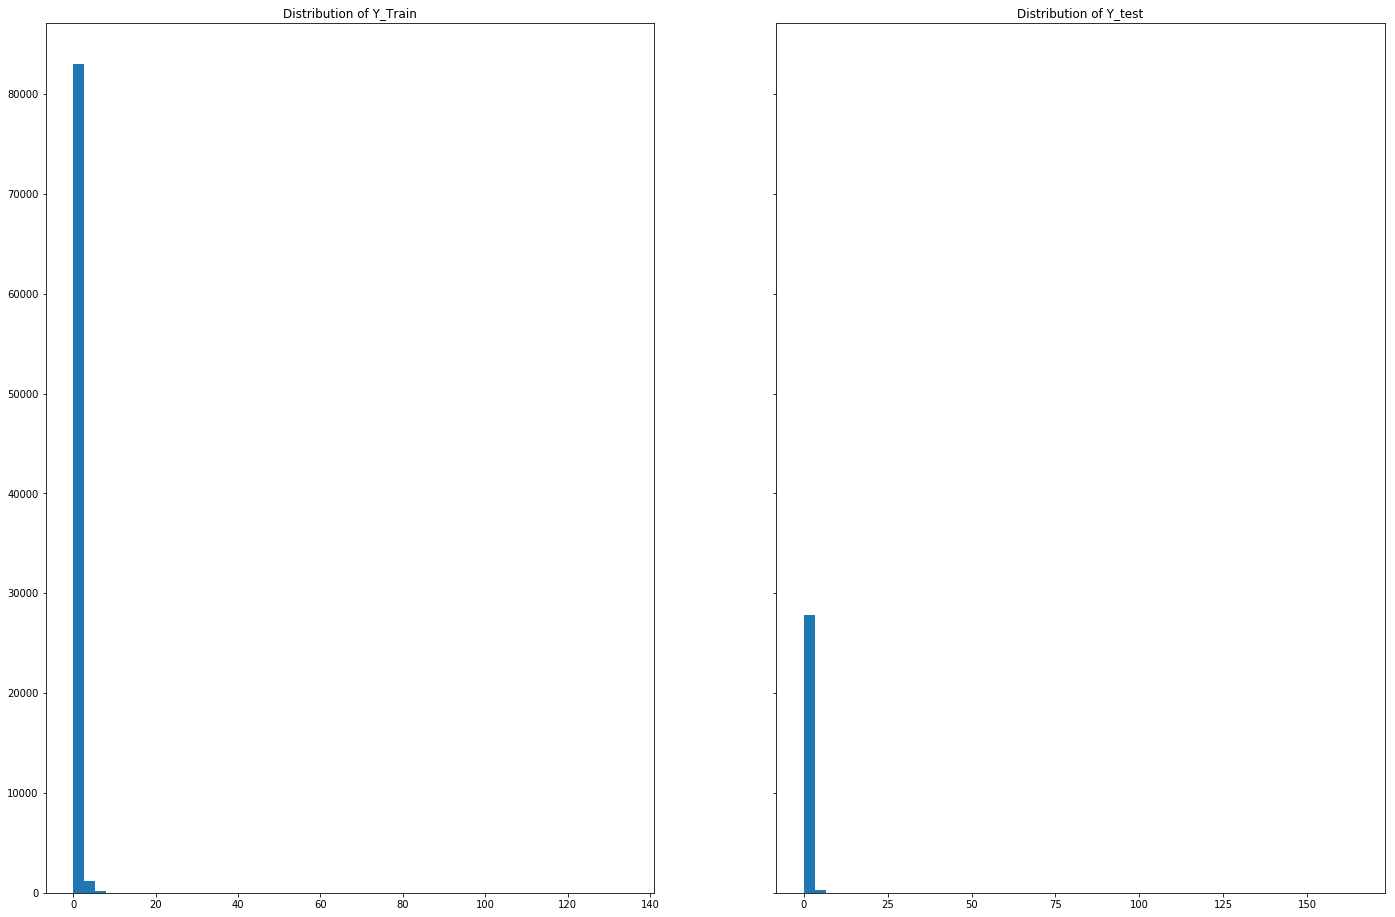

In [21]:
fig1, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize= [24,16])
ax1.hist(Y_train * max_vals[-1], bins=50)
ax1.title.set_text('Distribution of Y_Train')
ax2.hist(Y_test * max_vals[-1], bins=50)
ax2.title.set_text('Distribution of Y_test')

In [22]:
# calculate mean and std
mean_val = np.concatenate([Y_train, Y_test], axis=0).mean()
std = np.concatenate([Y_train, Y_test], axis=0).std()

print('mean dataset: %s'%(mean_val * max_vals[-1]))
print('std of dataset: %s'%(std * max_vals[-1]))

mean dataset: 0.281482299557
std of dataset: 1.28893990039


So will cut down to the mean of the trainng data +- 2 * std

In [23]:
# split data into input and label

threshold = mean_val + 2 * std
print(threshold)

train_data_cut = train_data[train_data['avg_spend_per_hour'] < threshold]
test_data_cut = test_data[test_data['avg_spend_per_hour'] < threshold]


Y_train = np.array(train_data_cut['avg_spend_per_hour'])
X_train = np.asarray(train_data_cut.drop('avg_spend_per_hour', axis=1))

Y_test = np.array(test_data_cut['avg_spend_per_hour'])
X_test = np.asarray(test_data_cut.drop('avg_spend_per_hour', axis=1))

print(np.shape(Y_train))
print(np.shape(X_train))
print(np.shape(Y_test))
print(np.shape(X_test))


0.0173410279601
(83084,)
(83084, 69)
(27755,)
(27755, 69)


In [24]:
##########################################################
#####            This will run for a while           #####
##### Maybe reduce parameters for faster walkthrough #####
##########################################################


# train model

# setup model and train with grid search
mlp = MLPRegressor(batch_size=256, early_stopping=True)
    
parameters = {
    'activation': ['tanh', 'relu'],
    'learning_rate_init':[0.01, 0.005, 0.001],
    'hidden_layer_sizes': [(100, 100), (50), (50, 50), (50, 50, 50), (25)]
}

cv = GridSearchCV(mlp, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)

# calclate mse
mse = mean_squared_error(Y_test, Y_pred)
r2_2 = r2_score(Y_test, Y_pred)
print(mse)

5.29535051495e-06


In [26]:
avg_total_error = np.sqrt(mse) * max_vals[-1]
print('Average total error: %s'%avg_total_error)

print('Mean of test data: %s:'%(Y_test.mean() * max_vals[-1]))
print('Mean of predictions: %s:'%(Y_pred.mean() * max_vals[-1]))
print('Mean of training data: %s:'%(Y_train.mean() * max_vals[-1]))

print('R2 Score: %s:'%(r2_2))

Average total error: 0.379438744226
Mean of test data: 0.198059036509:
Mean of predictions: 0.156586014087:
Mean of training data: 0.198733753941:
R2 Score: 0.0224268727503:


By dropping the rows with extreme spendings, the model improved quite a lot. Nevertheless the average error is still bigger than the mean of value of the dataset.

The R2-Score got even worse, so this does not seem to have worked either.

### Third approach

Next I will try another approach. First I will drop all users who did not provide personal information, since this might be quite relevant information

Next I am going to switch the way the train and test groups are definied. Maybe the model is better at predicting the future of people if it "knows their history", than predicting new users.

For that I am going to restructure the data, so that only data from the 5th status change on.

In [27]:
# do some preprocessing
threshold = 5

# load data
with open('ready_dataset.pkl', 'rb') as pf:
    ml_data_train, ml_data_test  = pickle.load(pf)
    
    
# drop users with no personal data
ml_data_train_drop = ml_data_train.dropna(axis=0, subset=['age'])
ml_data_test_drop = ml_data_test.dropna(axis=0, subset=['age'])

# only get interactions when at least 4 steps are known
train_data_new = []
old_id = ''
ctr = 0
for index, row in ml_data_train_drop.iterrows():
    if row.user_id == old_id:
        ctr += 1
    else:
        ctr = 0
        old_id = row.user_id
        
    if ctr >= threshold:
        train_data_new.append(row.values)
        
        
test_data_new = []
old_id = ''
ctr = 0
for index, row in ml_data_test_drop.iterrows():
    if row.user_id == old_id:
        ctr += 1
    else:
        ctr = 0
        old_id = row.user_id
        
    if ctr >= threshold:
        test_data_new.append(row.values)

train_data = pd.DataFrame(data=train_data_new, columns=columns)
test_data = pd.DataFrame(data=test_data_new, columns=columns)

print(train_data.shape)
print(test_data.shape)

(20792, 60)
(7072, 60)


In [28]:
# the columns money, user_id, timestamp und timeperiod are not needed anymore, hence drop them

train_data = train_data.drop(['user_id', 'timestamp', 'timeperiod', 'money'], axis=1)
test_data = test_data.drop(['user_id', 'timestamp', 'timeperiod', 'money'], axis=1)

# get dummies for age, gender and income
train_data = get_dummies(train_data, ['age', 'gender', 'income'])
test_data = get_dummies(test_data, ['age', 'gender', 'income'])

# normalize data

[train_data, test_data], min_vals, max_vals = normalize_data([train_data, test_data], joined_cols)

In [29]:
# get labes

train_label = np.array(train_data['avg_spend_per_hour'])
test_label = np.array(test_data['avg_spend_per_hour'])

In [30]:
# calculate mean and std
mean_val = np.concatenate([train_label, test_label], axis=0).mean()
std = np.concatenate([train_label, test_label], axis=0).std()

print('mean dataset: %s'%(mean_val * max_vals[-1]))
print('std of dataset: %s'%(std * max_vals[-1]))

mean dataset: 0.356185497027
std of dataset: 1.38901291311


In [31]:
# split data into input and label and remove outliers 

threshold = mean_val + 2 * std
print(threshold)

train_data_cut = train_data[train_data['avg_spend_per_hour'] < threshold]
test_data_cut = test_data[test_data['avg_spend_per_hour'] < threshold]

Y_train = np.array(train_data_cut['avg_spend_per_hour'])
X_train = np.asarray(train_data_cut.drop('avg_spend_per_hour', axis=1))

Y_test = np.array(test_data_cut['avg_spend_per_hour'])
X_test = np.asarray(test_data_cut.drop('avg_spend_per_hour', axis=1))

print(np.shape(Y_train))
print(np.shape(X_train))
print(np.shape(Y_test))
print(np.shape(X_test))


0.0233382577404
(20443,)
(20443, 69)
(6961,)
(6961, 69)


In [32]:
##########################################################
#####            This will run for a while           #####
##### Maybe reduce parameters for faster walkthrough #####
##########################################################


# train model

# setup model and train with grid search
mlp = MLPRegressor(batch_size=256, early_stopping=True)
    
parameters = {
    'activation': ['tanh', 'relu'],
    'learning_rate_init':[0.01, 0.005, 0.001],
    'hidden_layer_sizes': [(100, 100), (50), (50, 50), (50, 50, 50), (25)]
}

cv = GridSearchCV(mlp, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)

# calclate mse
mse = mean_squared_error(Y_test, Y_pred)
r2_3 = r2_score(Y_test, Y_pred)
print(mse)

1.11094187055e-05


In [33]:
avg_total_error = np.sqrt(mse) * max_vals[-1]
print('Average total error: %s'%avg_total_error)

print('Mean of test data: %s:'%(Y_test.mean() * max_vals[-1]))
print('Mean of predictions: %s:'%(Y_pred.mean() * max_vals[-1]))
print('Mean of training data: %s:'%(Y_train.mean() * max_vals[-1]))

print('R2 Score: %s:'%(r2_3))

Average total error: 0.44761590646
Mean of test data: 0.267220258821:
Mean of predictions: 0.314682388906:
Mean of training data: 0.258796079845:
R2 Score: 0.0721052139006:


Below are shown the performance comparisons of the three models

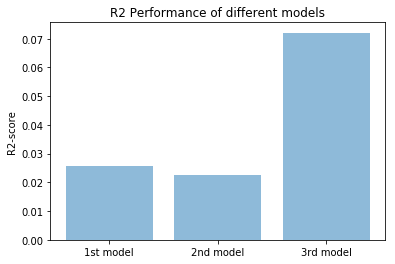

In [35]:
plt.bar([1,2,3], [r2_1, r2_2, r2_3], align='center', alpha=0.5)
plt.xticks([1,2,3], ['1st model', '2nd model', '3rd model'])
plt.ylabel('R2-score')
plt.title('R2 Performance of different models')

plt.show()

The last one got a little better, so it seems that a stronger focus on personal history and removing the people with no personal data die improve the model, nevertheless it is still close to guessing.

# New Approach with statistics

Lastly I will approach the problem with statistics. I will try to figure out which age, gender and income group is most influenced by which type of offer.

In [37]:
# load data
with open('ready_dataset.pkl', 'rb') as pf:
    ml_data_train, ml_data_test  = pickle.load(pf)
    
data = pd.concat([ml_data_train, ml_data_test], axis=0)

# drop users with no personal data
data = data.dropna(axis=0, subset=['age'])

# from the dataset, the last timestamp (714) for each user provides the summed up times and amounts spent
summs = data[data['timestamp'] == 714]


# Next the tables for each age and inocme combination sorted by gender will be set up for each offer type and no offer
cat_dict = get_category_dict(portfolio)

info_summary = {'M_times': np.zeros([7,7]), 'M_amounts': np.zeros([7,7]),
                'F_times': np.zeros([7,7]), 'F_amounts': np.zeros([7,7]),
                'O_times': np.zeros([7,7]), 'O_amounts': np.zeros([7,7])}

bogo_summary = {'M_times': np.zeros([7,7]), 'M_amounts': np.zeros([7,7]),
                'F_times': np.zeros([7,7]), 'F_amounts': np.zeros([7,7]),
                'O_times': np.zeros([7,7]), 'O_amounts': np.zeros([7,7])}

disc_summary = {'M_times': np.zeros([7,7]), 'M_amounts': np.zeros([7,7]),
                'F_times': np.zeros([7,7]), 'F_amounts': np.zeros([7,7]),
                'O_times': np.zeros([7,7]), 'O_amounts': np.zeros([7,7])}

none_summary = {'M_times': np.zeros([7,7]), 'M_amounts': np.zeros([7,7]),
                'F_times': np.zeros([7,7]), 'F_amounts': np.zeros([7,7]),
                'O_times': np.zeros([7,7]), 'O_amounts': np.zeros([7,7])}


nums = {'M': np.zeros([7,7]), 'F': np.zeros([7,7]), 'O': np.zeros([7,7])}

for index, user in summs.iterrows():
    for i, key in enumerate(cat_dict.keys()):
        cat = cat_dict[key]
        if cat=='informational':
            info_summary['%s_times'%user.gender][int(user.age), int(user.income)] += user['total_time_offer_viewed_active_%i'%(i+1)]
            info_summary['%s_amounts'%user.gender][int(user.age), int(user.income)] += user['money_spent_after_viewed_offer_%i'%(i+1)]
            
        elif cat=='bogo':
            bogo_summary['%s_times'%user.gender][int(user.age), int(user.income)] += user['total_time_offer_viewed_active_%i'%(i+1)]
            bogo_summary['%s_amounts'%user.gender][int(user.age), int(user.income)] += user['money_spent_after_viewed_offer_%i'%(i+1)]
            
        elif cat=='discount':
            disc_summary['%s_times'%user.gender][int(user.age), int(user.income)] += user['total_time_offer_viewed_active_%i'%(i+1)]
            disc_summary['%s_amounts'%user.gender][int(user.age), int(user.income)] += user['money_spent_after_viewed_offer_%i'%(i+1)]
            
        nums[user.gender][int(user.age), int(user.income)] += 1 
    none_summary['%s_times'%user.gender][int(user.age), int(user.income)] += user['time_no_active_offer']
    none_summary['%s_amounts'%user.gender][int(user.age), int(user.income)] += user['money_spend_no_offer']
    


One downside of this model is, that the model has a very heterogenous spread of data. Some groups have a very high number of datapoints while others , especially for "other" gender, have little to no datapoints available. Hence in those cases the prediction is worse than in those with many datapoints. The distributions can be seen below.

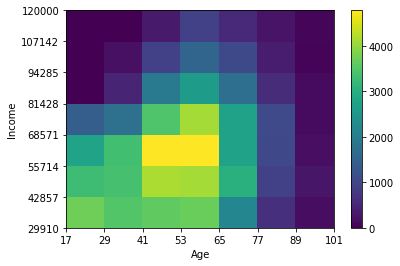

In [60]:
# plot number of occurences for male

x_label=[]
y_label=[]

for i in range(8):
    x_label.append(int(age_borders[i]))
    y_label.append(int(income_borders[i]))


plt.pcolormesh(range(8), range(8), nums['M'].transpose(), shading='auto')
plt.xticks(range(8), x_label)
plt.yticks(range(8), y_label)
plt.xlabel('Age')
plt.ylabel('Income')
plt.colorbar()
plt.show()

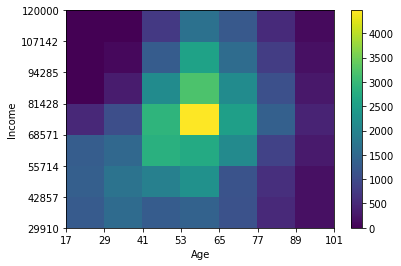

In [61]:
# plot number of occurences for female

plt.pcolormesh(range(8), range(8), nums['F'].transpose(), shading='auto')
plt.xticks(range(8), x_label)
plt.yticks(range(8), y_label)
plt.xlabel('Age')
plt.ylabel('Income')
plt.colorbar()
plt.show()

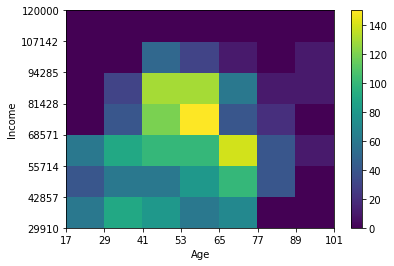

In [62]:
# plot number of occurences for other

plt.pcolormesh(range(8), range(8), nums['O'].transpose(), shading='auto')
plt.xticks(range(8), x_label)
plt.yticks(range(8), y_label)
plt.xlabel('Age')
plt.ylabel('Income')
plt.colorbar()
plt.show()

In [53]:
# save data
with open('statistical_data.pkl', 'wb') as pf:
    pickle.dump([info_summary, bogo_summary, disc_summary, none_summary], pf)

In [54]:
def get_results(gender, age, income):
    """
    Get result for gender, income group and age goup
    
    Arguments:
    -------------------
    gender:          gender of user (M, F, O)
    age:             ag group of user (0 - 6)
    income:          income group of user (0 - 6)
    
    
    Returns:
    -------------------
    times:           times while each offer type was open and none  (info, bogo, discount, none)
    amounts:         amounts spent while each offer type was open  (info, bogo, discount, none)
    """
    # load data
    with open('statistical_data.pkl', 'rb') as pf:
        info_summary, bogo_summary, disc_summary, none_summary = pickle.load(pf)
    
    # set output data
    times = [info_summary['%s_times'%gender][int(age), int(income)],
            bogo_summary['%s_times'%gender][int(age), int(income)],
            disc_summary['%s_times'%gender][int(age), int(income)],
            none_summary['%s_times'%gender][int(age), int(income)]]
    amounts = [info_summary['%s_amounts'%gender][int(age), int(income)],
            bogo_summary['%s_amounts'%gender][int(age), int(income)],
            disc_summary['%s_amounts'%gender][int(age), int(income)],
            none_summary['%s_amounts'%gender][int(age), int(income)]]
    
    return np.asarray(times), np.asarray(amounts)
    

In [57]:
# some examples

times, amounts = get_results('F', 5, 5)
ex1 = amounts / times
print(amounts / times)
times, amounts = get_results('F', 6, 2)
ex2 = amounts / times
print(amounts / times)
times, amounts = get_results('F', 0, 2)
print(amounts / times)
times, amounts = get_results('O', 4, 3)
print(amounts / times)
times, amounts = get_results('O', 5, 1)
print(amounts / times)
times, amounts = get_results('O', 6, 3)
print(amounts / times)
times, amounts = get_results('M', 1, 4)
ex3 = amounts / times
print(amounts / times)
times, amounts = get_results('M', 5, 2)
print(amounts / times)
times, amounts = get_results('M', 3, 4)
ex4 = amounts / times
print(amounts / times)


[ 0.38352635  0.42844444  0.53717043  0.1773417 ]
[ 0.14741898  0.15847443  0.11459474  0.1261515 ]
[ 0.22384994  0.20952695  0.17721133  0.16370935]
[ 0.          0.50602694  0.2410119   0.19710177]
[ 0.072625    0.07682222  0.08775463  0.0730303 ]
[ nan  nan  nan  nan]
[ 0.19079204  0.16697045  0.18597529  0.27449553]
[ 0.20124668  0.18257416  0.19049536  0.12088001]
[ 0.29519805  0.2434063   0.24925722  0.16518925]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


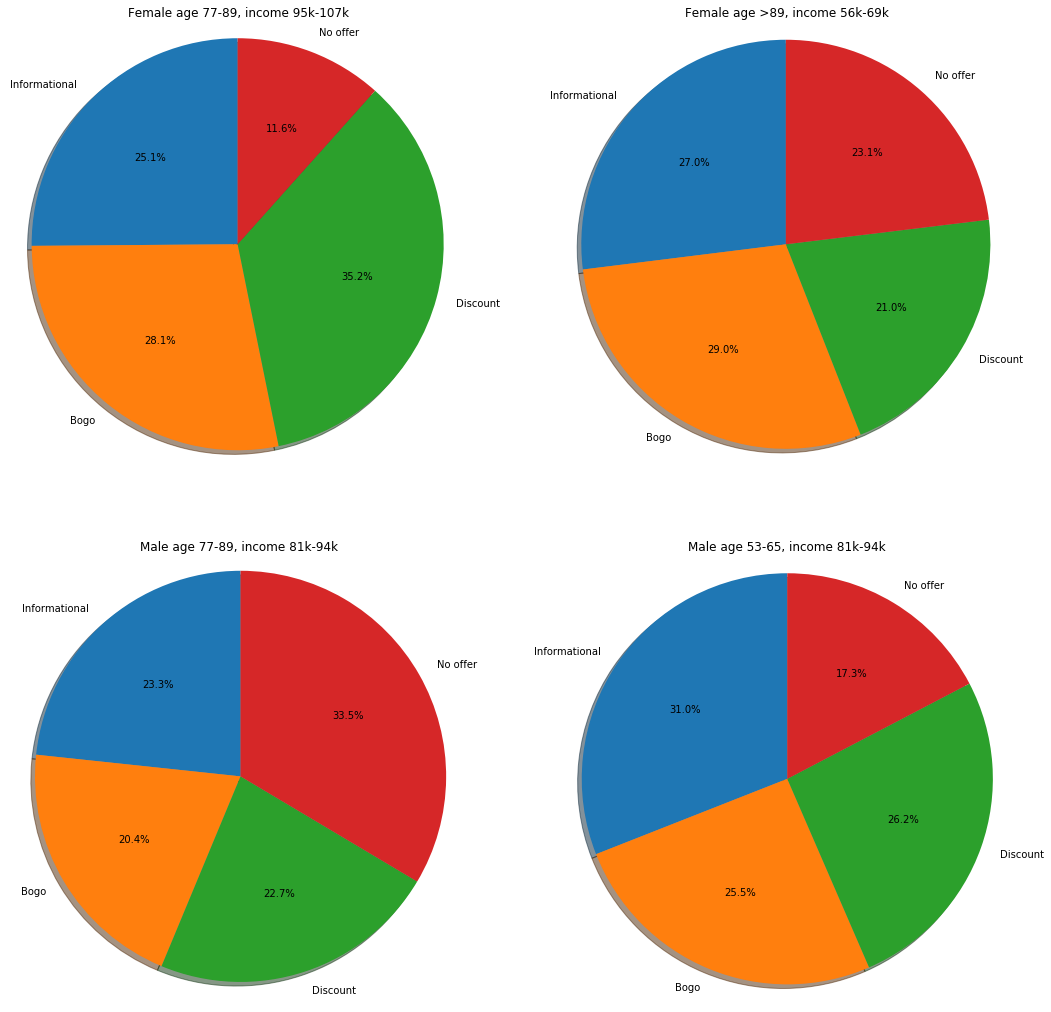

In [71]:
labels = ['Informational', 'Bogo', 'Discount', 'No offer']

fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize= [18,18])
ax1.pie(ex1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Female age 77-89, income 95k-107k')


ax2.pie(ex2*2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title('Female age >89, income 56k-69k')


ax3.pie(ex3*2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal') 
ax3.set_title('Male age 77-89, income 81k-94k')


ax4.pie(ex4*2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')
ax4.set_title('Male age 53-65, income 81k-94k')

plt.show()

In [ ]:
[  17.917        29.85714286   41.71428571   53.57142857   65.42857143
   77.28571429   89.14285714  101.        ]
[  29910.           42857.14285714   55714.28571429   68571.42857143
   81428.57142857   94285.71428571  107142.85714286  120000.        ]

## Results

With this statistical model it can be seen, that differnt group react very differently to different kinds of offers.
While fo example rather old women with a high income semm to tripple their spendings when they get a discount offer, old women with a low income don't seem to be much affected by any offer type.

Young males with medium income seem to even react negetivly to any kind of offer and spend more money when they don't receive any offer at all.

# Conclusion

At first I tried to tackle the problem with different settings of a neural network, based on user statistics and also the personal history of a user. This did not go very well. 
Removing the outliers improved the model quite a bit, but still the average error was way to high to call a success.

In a third run I tried to remove the users who don't provide any personal background and also only include the steps where already some personal history was known, in the hope that this would improve the model. The downside was, that this step reduced the dataset size to approximatly only 25% of the original dataset. This smaller dataset seems to have a greater negativ effect than the potentially better data could improve the model. Overall it got even a little worse.

So in another attempt I removed all users who did not provide any personal background. Then I categoized the offers by the three types and then looked how much money each group (seven income bins, seven age bins and three genders) spend per hour in average, depending on which offers were viewed.

Those results are quite interesting, since there seems to be a very different behaviour across different groups. So in the end this will be my final proposal.
The function get_results can be fed with gender, age group and income group and will return the times and amounts spend for each offer type.

The problem is, that as can be seen in the income, age, gender graph is, that not for all combinations of gender, income and age there are any datapoints. So for example for very young ppl with a very high income there is no reference so far. In that case and also cases where there are very few datapoints there should be more exploration done, while in areas where there are already many datapoints, explotation can be quite a successfull way to go about.

# Further discussions

There are a few other possible ways. For example maybe the ml model would be better if the data was fewer and it was split only between the three offer types and not the ten different offers.

Also a question that arises is, how to deal with the exploration versus explotation difficulty. I think a general good way to go is the more data their already is the more explotation, and the less there is the more exploration, to further improve the model.

If ppl sign up who don't have any personal data given, I would start with offers 5 and 6 being considering view and completion rate the most liked once.

And maybe if the dataset reaches a much higher level of more users and e.g. ~1/2 year or more record a model taken the personal history into account could be tried again.